### Data import

In [1]:
import csv
import os
import numpy as np
import seaborn as sns

sns.set()

data_file_name = 'data/data-tettamanzi-complete.csv'

with open(data_file_name) as data_file:
    data = np.array(list(csv.reader(data_file)))

n = len(data) - 1

print('{} data items'.format(n))

1444 data items


In [2]:
labels = data[0][1:]

In [3]:
# uncomment next line for using only a subset of the available data
# n = 1444

names = np.array(data[0])[1:n+1]
mu = np.array([float(row[0]) for row in data[1:n+1]])
#gram_jaccard = np.array([[float(k.replace('NA', '0'))
#                          for k in row[1:n+1]] for row in data[1:n+1]])

assert(len(names.shape) == 1)
assert(len(mu.shape) == 1)

if not os.path.isfile('mu.npy'):
    print('caching membership file...', end=' ')
    np.save('mu.npy', mu)
    print('done!')

if os.path.isfile('jaccard_similarity.npy'):
    print('revrieving cached jaccard similarity data matrix')
    gram_jaccard = np.load('jaccard_similarity.npy')
else:
    print('generating and caching jaccard similarity data matrix...', end=' ')
    gram_jaccard = np.array([[float(k.replace('NA', '0'))
                              for k in row[1:n+1]] for row in data[1:n+1]])
    np.save('jaccard_similarity.npy', gram_jaccard)
    print('done!')
    
assert(len(gram_jaccard.shape) == 2)
assert(names.shape[0] == gram_jaccard.shape[0]
       == gram_jaccard.shape[1] == mu.shape[0])

dist_jaccard = 1 - gram_jaccard

revrieving cached jaccard similarity data matrix


### Initial t-SNE using Jaccard-like similarity between axioms

We use the Jaccard-like similarity in order to drive the classical t-SNE procedure mapping candidate axioms onto bidimensional points.

In [4]:
import time
import datetime
import math
from sklearn.manifold import TSNE

rs = 20190105

# this is just to print time values in a more human readable form


def to_hhmmss(secs):
    times = list(map(int, (str(datetime.timedelta(seconds=math.floor(secs)))
                           .split(':'))))
    units = ('hour', 'minute', 'second')
    plurals = ['s' if int(t) else '' for t in times]

    return ' '.join(['{} {}{}'.format(t, u, p)
                     for t, u, p in zip(times, units, plurals) if t])


time_start = time.time()
# use the optional argument random_state in order to set the random seed
# REMEMBER: t-SNE requires a precomputed DISTANCE matrix
X_tsne_jaccard = TSNE(
    random_state=rs, metric='precomputed').fit_transform(dist_jaccard)
tsne_time = to_hhmmss(time.time()-time_start)
print('t-SNE with two components done! Time elapsed: {}'.format(tsne_time))

t-SNE with two components done! Time elapsed: 8 seconds


We can now scatter the obtained points, coloring them according to their score.

In [5]:
import matplotlib as mpl

C = np.array([(i, i, i) for i in range(0, 200)])

graycols = mpl.colors.ListedColormap(C/255.0)

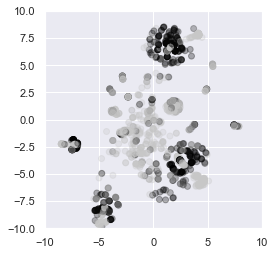

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
#from matplotlib import cm

plt.scatter(*X_tsne_jaccard.transpose(), c=mu, cmap=graycols, alpha=0.3)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

We can also abstract a more general function which is able to display using different bullets non-negated and negated formulas (of course, + will refer to the former formulas, and - to the latter). This function is also able to filter out formulas on the basis of the content of their labels, although for the moment we will not use this feature.

In [7]:
import re
from matplotlib.colors import Normalize


def build_filter(criterion, only_antecedent=True):
    if only_antecedent:
        p = re.compile(r'.*' + criterion + '\s.*')
    else:
        p = re.compile(r'.*' + criterion + '.*')
    return lambda l, pos: p.match(l) and l[2] == ('S' if pos else '-')


def signed_axioms_plot(x_red, mu, labels, criterion,
                       verbose=False, only_antecedent=True):

    filter = build_filter(criterion, only_antecedent)

    x, y = x_red.transpose()

    if verbose:
        print([(i, l) for i, l in enumerate(labels) if filter(l, True)][:10])

    x_filt_pos = x[[i for i, l in enumerate(labels) if filter(l, True)]]
    x_filt_neg = x[[i for i, l in enumerate(labels) if filter(l, False)]]

    y_filt_pos = y[[i for i, l in enumerate(labels) if filter(l, True)]]
    y_filt_neg = y[[i for i, l in enumerate(labels) if filter(l, False)]]
    mu_filt_pos = mu[[i for i, l in enumerate(labels) if filter(l, True)]]
    mu_filt_neg = mu[[i for i, l in enumerate(labels) if filter(l, False)]]
    labels_filt_pos = labels[[i for i, l in enumerate(labels)
                                  if filter(l, True)]]
    labels_filt_neg = labels[[i for i, l in enumerate(labels)
                                  if filter(l, False)]]

    fig, ax = plt.subplots()

    data = np.array([[[x_filt_pos[i], x_filt_neg[i]],
                      [y_filt_pos[i], y_filt_neg[i]]]
                     for i in range(len(x_filt_pos))])

    scatter_pos = plt.scatter(x_filt_pos, y_filt_pos,
                              c=mu_filt_pos, cmap=graycols,
                              alpha=0.5, marker='+', norm=Normalize(0, 1))

    scatter_neg = plt.scatter(x_filt_neg, y_filt_neg,
                              c=mu_filt_neg, cmap=graycols,
                              alpha=0.5, marker='_', norm=Normalize(0, 1))

    return fig

The following cell defines a function directly starts from a precomputed data matrix, apply a dimensionality reduction procedure and show the scatter plot of its results. It also defines a handy function directly applying the t-SNE procedure.

In [8]:
def reduce_and_scatter(data_matrix, reduction_procedure, mu, labels):
    # REMEMBER: t-SNE requires a precomputed DISTANCE matrix,
    # while PCA requires a precomputed SIMILARITY matrix.
    X_red = reduction_procedure(data_matrix)
    signed_axioms_plot(X_red, mu, labels, '')
    #plt.show()
    return X_red


def tsne(dist_matrix):
    return TSNE(random_state=rs,
                metric='precomputed').fit_transform(dist_matrix)

Let's check that we obtain a consistent result if we use t-SNE and the Jaccard-like precomputed distance matrix:

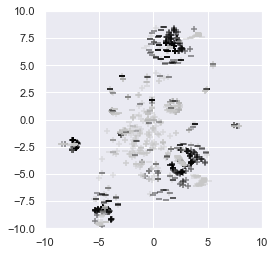

In [9]:
X_tsne_jaccard = reduce_and_scatter(dist_jaccard, tsne, mu, labels)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

## Using different similarities for t-SNE

We can now use the `reduce_and_scatter` function in conjunction with different similarity criteria.

### Formula-length similarity

We start by considering a very simple, yet likely unsuitable similarity measure: the absolute value of the difference of the lengths of candidate axioms' textual representations. More precisely, as we will need to convert such distance into a similarity measure, we also normalize the distance $d(f_1, f_2)$ dividing its value by its upper bound $\max(|f_1|, |f_2|)$, where $|s|$ denotes the length of a string.  A _caveat_ shall be introduced, however: as some formulas are negated and some aren't, a naive implementation of the lenght-based distance would return almost 1 when fed with a formula and its logical negation, we consider the usual normalized distance between formulas after trimming the initial `-` sign (if it is present), and subsequently compute the complement to 1 of the result if one and only one of the formulas is negated.

revrieving cached length distance data matrix


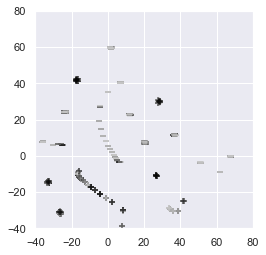

In [10]:
def get_data_matrix(file, name, function):
    if os.path.isfile(file):
        print('revrieving cached {} data matrix'.format(name))
        data_matrix = np.load(file)
    else:
        print('generating and caching {} data matrix'
              ' (could take considerable time)...'.format(name), end=' ')
        data_matrix = np.array([[function(ax1, ax2)
                                for ax1 in labels] for ax2 in labels])
        np.save(file, data_matrix)
        print('done!')
    return data_matrix

def _length_distance(ax1, ax2):
    return abs(len(ax1) - len(ax2)) / max(len(ax1), len(ax2))



def length_distance(ax1, ax2):
    sign_negated = 1

    ax1_clean = ax1[2:-1]
    if ax1_clean[0] == '-':
        sign_negated *= -1
        ax1_clean = ax1_clean[1:]

    ax2_clean = ax2[2:-1]
    if ax2_clean[0] == '-':
        sign_negated *= -1
        ax2_clean = ax2_clean[1:]
    
    e = _length_distance(ax1_clean, ax2_clean)
    
    assert(0 <= e <= 1)
    
    return e if sign_negated == 1 else 1-e


dist_length = get_data_matrix('length_distance.npy',
                              'length distance', length_distance)


X_tsne_length = reduce_and_scatter(dist_length, tsne, mu, labels)
plt.xlim(-40, 80)
plt.ylim(-40, 80)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Levenshtein similarity

In this section we focus on the similarity measure obtained when considering the Levenshtein distance (aka edit distance) between the textual description of the formulas. As the computation of the corresponding matrix requires a significant amount of time, once computed this matrix has been saved in a file named `distance_levenshtein_similarity.npy`. We apply here the same _caveat_ dealing with couples of negated formulas.

In [11]:
_edit_distance?

Object `_edit_distance` not found.


revrieving cached levenshtein distance data matrix


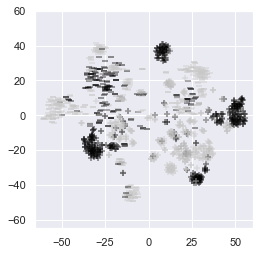

In [12]:
import os
from nltk.metrics.distance import edit_distance as _edit_distance

def edit_distance(ax1, ax2):
    sign_negated = 1

    ax1_clean = ax1[2:-1]
    if ax1_clean[0] == '-':
        sign_negated *= -1
        ax1_clean = ax1_clean[1:]

    ax2_clean = ax2[2:-1]
    if ax2_clean[0] == '-':
        sign_negated *= -1
        ax2_clean = ax2_clean[1:]
    
    e = _edit_distance(ax1_clean, ax2_clean) / (max(len(ax1), len(ax2)) - 3)
    
    # normalization here follows by the fact that the maximal edit
    # distance between two words is the length of the longest word
    # -3 here stands for "do not consider quotes and initial space"
    assert(0 <= e <= 1)
    
    return e if sign_negated == 1 else 1-e


dist_leven = get_data_matrix('levenshtein_distance.npy',
                              'levenshtein distance', edit_distance)

X_tsne_leven = reduce_and_scatter(dist_leven, tsne, mu, labels)
plt.xlim(-65, 60)
plt.ylim(-65, 60)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Hamming similarity

Finally, we considered the similarity measure induced by the normalized Hamming distance between the textual description of the formulas, only considering the first part of the longer string. Again, we use the above mentioned _caveat_.

revrieving cached hamming distance data matrix


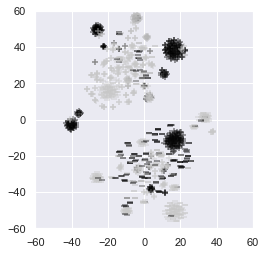

In [13]:
def hamming(ax1, ax2):
    sign_negated = 1

    ax1_clean = ax1[2:-1]
    if ax1_clean[0] == '-':
        sign_negated *= -1
        ax1_clean = ax1_clean[1:]

    ax2_clean = ax2[2:-1]
    if ax2_clean[0] == '-':
        sign_negated *= -1
        ax2_clean = ax2_clean[1:]

    pairs = list(zip(ax1_clean, ax2_clean))
    h = sum([ch1 != ch2
             for ch1, ch2 in pairs]) / (min(len(ax1), len(ax2)) - 3)
    # -3 here stands for "do not consider quotes and initial space"
    
    assert(0 <= h <= 1)
    return h if sign_negated == 1 else 1-h

dist_hamming = get_data_matrix('hamming_distance.npy',
                              'hamming distance', hamming)

X_tsne_hamming = reduce_and_scatter(dist_hamming, tsne, mu, labels)
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

## Transforming formulas via kernel PCA

Here we re-run the experiments of previous sections using the kernel PCA technique instead of t-SNE.

In [14]:
from sklearn.decomposition import KernelPCA


def pca(gram_matrix):
    return KernelPCA(n_components=2,
                     random_state=rs,
                     kernel='precomputed').fit_transform(gram_matrix)

### Jaccard-like similarity

We already have the Gram matrix for the Jaccard-like similarity.

/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


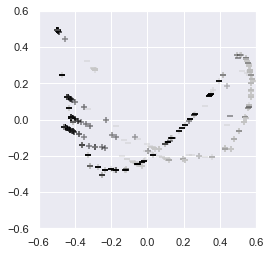

In [15]:
X_pca_jaccard = reduce_and_scatter(gram_jaccard, pca, mu, labels)
plt.xlim(-.6, .6)
plt.ylim(-.6, .6)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Formula-length similarity

As all the distances we have considered are by definition within $[0, 1]$, their complement to 1 has the properties of a similarity measure.

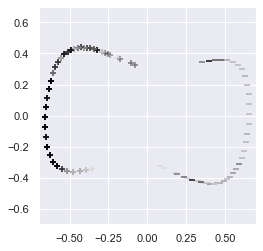

In [16]:
gram_length = 1 - dist_length
X_pca_length = reduce_and_scatter(gram_length, pca, mu, labels)
plt.xlim(-.7, .7)
plt.ylim(-.7, .7)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Levenshtein similarity

The Levenshtein similarity is handled exactly as in previous section.

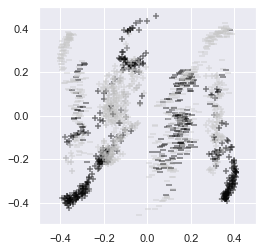

In [17]:
gram_leven = 1 - dist_leven
X_pca_leven = reduce_and_scatter(gram_leven, pca, mu, labels)
plt.xlim(-.5, .5)
plt.ylim(-.5, .5)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Hamming similarity

Hamming similarity is easy to deal with, as the Gram matrix is directly obtained via complement of the distance matrix.

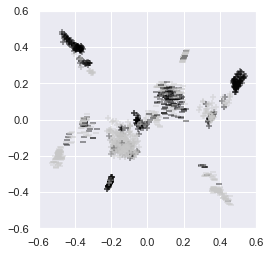

In [18]:
gram_hamming = 1 - dist_hamming
X_pca_hamming = reduce_and_scatter(gram_hamming, pca, mu, labels)
plt.xlim(-.6, .6)
plt.ylim(-.6, .6)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

## Combining PCA with t-SNE

Following a well consolidated protocol, we perform here the dimensionality reduction process as a two-stage procedure: first we use PCA in order to eliminate the less informative features, and subsequently we apply t-SNE. Of course in this case the considered similarity measures only apply to the first stage, as in the second one we are dealing wit 2D points.

In order to decide how many features we want to retain on the first stage, we extract 300 principal components and check how the cumulative information scales with the number of considered components.

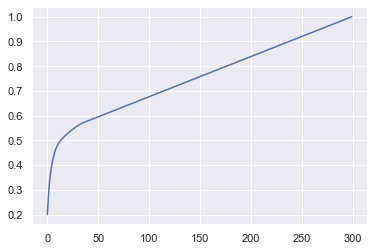

In [19]:
pca_trasf = KernelPCA(n_components=300,
                      random_state=rs, kernel='precomputed')
pca_trasf.fit(gram_jaccard)

energy_perc = pca_trasf.lambdas_/sum(pca_trasf.lambdas_)
tot_energy_perc = np.cumsum(energy_perc)

plt.plot(range(300), tot_energy_perc)
plt.show()

This graph shows that with slightly less than 150 components we get the 75% of the total information. We can be more precise by computing the precise number of components leading to that figure.

In [20]:
num_comp = 0
while tot_energy_perc[num_comp] < .75:
    num_comp += 1

num_comp += 1
print(num_comp)

147


Here below we redefine the function showing the results of the reduction process, now performing both PCA and t-SNE. We add a parameter fixing the percentage of information to be retained, and fix its default to 75%.

In [21]:
def pca_tsne(gram_matrix, retained_energy=0.75):
    pca_trasf = KernelPCA(n_components=300,
                          random_state=rs,
                          kernel='precomputed').fit(gram_matrix)
    energy_perc = pca_trasf.lambdas_/sum(pca_trasf.lambdas_)
    tot_energy_perc = np.cumsum(energy_perc)
    num_comp = 0
    while tot_energy_perc[num_comp] < retained_energy:
        num_comp += 1

    num_comp += 1
    X_pca = KernelPCA(n_components=num_comp,
                      random_state=rs,
                      kernel='precomputed').fit_transform(gram_matrix)
    X_pca_tsne = TSNE(random_state=rs).fit_transform(X_pca)
    return X_pca_tsne

### Jaccard-like similarity

/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


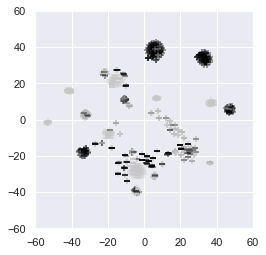

In [22]:
X_pca_tsne_jaccard = reduce_and_scatter(gram_jaccard, pca_tsne, mu, labels)
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Length-based similarity


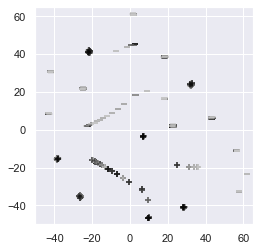

In [23]:
X_pca_tsne_length = reduce_and_scatter(gram_length, pca_tsne, mu, labels)
plt.xlim(-50, 65)
plt.ylim(-50, 65)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Levenshtein similarity

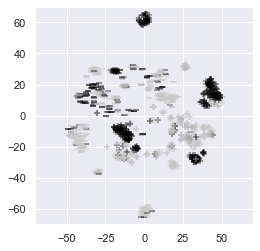

In [24]:
X_pca_tsne_leven = reduce_and_scatter(gram_leven, pca_tsne, mu, labels)
plt.xlim(-70, 70)
plt.ylim(-70, 70)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

### Hamming similarity

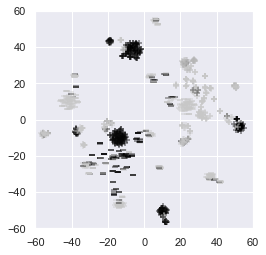

In [25]:
X_pca_tsne_hamming = reduce_and_scatter(gram_hamming, pca_tsne, mu, labels)
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.gca().set_aspect('equal', adjustable='box')

plt.draw()

## Computing the average radius of formulas in reduced space

In order to be able to compare the results obtained so far not only in qualitative terms, we introduce here the quantitative concept of _diameter_ of a formula in the reduced space. As after the dimensionality reduction process each formula is identified by a point in $\mathbb R^2$, we can score the reduction process itself via checking how scattered are semantically related formulas. In particular, we can fix a possible value for antecedents of the subsumption axioms, isolate separately all positive and negative formulas containing that value and consider the corresponding points in the real plane. We call _diameter_ of the formula a specific statistics describing the distance between such points. In particular, we will consider the maximum distance, as well as the mean and median distance, each coupled with a related variability indicator (respectively, standard deviation and interquartile range). Such diameters will be computed separately for positive and negative formulas. Intuitively, a good dimensionality reduction process should give rise to small values of the diameters. Moreover, it is also reasonable to reward the fact that positive and negative formulas are well separated if we consider their images, thus we will also compute the distance between the average position of 2D points for the two categories of formulas. Here, we will reward a process if it results in higher inter-category distances.

We start by extracting all values for antecedents, as well as those for the both antecedents and consequents, as we will repeat this experiment considering both components of the axioms.

In [26]:
p_antecedents = re.compile(r'.*:(.*)\s.*')
p_all = re.compile(r'.*:(.*)\s.*:(.*)\).*')

all_concepts = set()
antecedent_concepts = set()

for l in labels:
    m = p_all.match(l)
    all_concepts.update(m.groups())

    m = p_antecedents.match(l)
    antecedent_concepts.update(m.groups())

all_concepts = list(all_concepts)
all_concepts.sort()

antecedent_concepts = list(antecedent_concepts)
antecedent_concepts.sort()

We define here below a function that, starting from the points obtained using a specific reduction technique, associates a specific value for antecedents to the descriptive statistics for the corresponding diameter. We equip this function in order to be able to consider only antecedents or also consequents, via the use of an optional argument `only_antecedent`.

In [27]:
import scipy.stats as st


def get_concept_diameter(concept, labels, x_red, only_antecedent=True):

    filter = build_filter(concept, only_antecedent=only_antecedent)

    x, y = x_red.transpose()

    pos_indices = [i for i, l in enumerate(labels) if filter(l, True)]
    neg_indices = [i for i, l in enumerate(labels) if filter(l, False)]

    x_filtered_pos = x[pos_indices]
    x_filtered_neg = x[neg_indices]

    y_filtered_pos = y[pos_indices]
    y_filtered_neg = y[neg_indices]

    selected_pos = list(map(np.array, zip(x_filtered_pos, y_filtered_pos)))
    selected_neg = list(map(np.array, zip(x_filtered_neg, y_filtered_neg)))

    pos_centroid = np.mean(selected_pos, axis=0)
    neg_centroid = np.mean(selected_neg, axis=0)
    centroids_distance = np.linalg.norm(pos_centroid - neg_centroid)

    dist_pos = [np.linalg.norm(p1 - p2)
                for p1 in selected_pos for p2 in selected_pos]
    dist_neg = [np.linalg.norm(p1 - p2)
                for p1 in selected_neg for p2 in selected_neg]

    clust_desc = {'pos_max': max(dist_pos),
                  'pos_median': np.median(dist_pos),
                  'pos_iqr': st.iqr(dist_pos),
                  'pos_mean': np.mean(dist_pos),
                  'pos_std': np.std(dist_pos),
                  'neg_max': max(dist_neg),
                  'neg_median': np.median(dist_neg),
                  'neg_iqr': st.iqr(dist_neg),
                  'neg_mean': np.mean(dist_neg),
                  'neg_std': np.std(dist_neg),
                  'clusters_dist': centroids_distance}

    return clust_desc

We are now ready to compute the diameter values. As a first attempt, we focus on the t-SNE technique coupled with the Jaccard-like similarity, and sort the results according to a decreasing value for the distance between positive and negative formulas.

In [28]:
import pandas as pd

max_length = 21


def shorten_index(s):
    return s if len(s) <= max_length \
        else s[:(max_length-3)//2] + '...' + s[-(max_length-3)//2:]


res = pd.DataFrame([get_concept_diameter(c, labels, X_tsne_jaccard,
                                         only_antecedent=True)
                    for c in antecedent_concepts],
                   index=list(map(shorten_index, antecedent_concepts)))

res = res.sort_values(by='clusters_dist', axis=0, ascending=False)

column_order = ['clusters_dist',
                'pos_max', 'pos_median', 'pos_iqr', 'pos_mean', 'pos_std',
                'neg_max', 'neg_median', 'neg_iqr', 'neg_mean', 'neg_std']
res = res.reindex(column_order, axis=1)


def float_formatter(x): return '{:.2f}'.format(x)


def sci_formatter(x): return '{:.1e}'.format(x)


def var_formatter(x): return '±{:.2f}'.format(x)


res.style.format({'clusters_dist': float_formatter,
                  'pos_max': sci_formatter,
                  'pos_median': sci_formatter,
                  'pos_iqr': var_formatter,
                  'pos_mean': sci_formatter,
                  'pos_std': var_formatter,
                  'neg_max': sci_formatter,
                  'neg_median': sci_formatter,
                  'neg_iqr': var_formatter,
                  'neg_mean': sci_formatter,
                  'neg_std': var_formatter})

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
VolleyballCoach,8.86,8.3e-01,2.4e-07,±0.83,2.7e-01,±0.39,1.4e-01,5.1e-07,±0.14,4.4e-02,±0.06
BeautyQueen,7.84,5.6e-04,1.9e-04,±0.00,2.2e-04,±0.00,1.8e-01,6.0e-02,±0.09,7.0e-02,±0.06
Chancellor,7.11,4.3e-01,8.5e-02,±0.35,1.4e-01,±0.15,1.7e+00,1.1e-02,±1.68,4.7e-01,±0.75
Presenter,6.80,8.6e+00,3.7e-01,±8.20,3.5e+00,±4.04,2.7e+00,3.6e-01,±2.24,1.1e+00,±1.08
RadioHost,5.99,3.0e-01,1.2e-04,±0.30,8.4e-02,±0.14,1.7e-03,8.9e-07,±0.00,4.8e-04,±0.00
Racecourse,5.42,8.2e+00,1.4e-01,±7.87,2.3e+00,±3.58,8.0e+00,5.1e-02,±7.99,2.2e+00,±3.57
Chef,5.30,8.4e+00,1.5e+00,±7.42,2.8e+00,±3.32,8.4e+00,1.3e-01,±8.32,2.4e+00,±3.72
SportComp...ionResult,4.59,8.0e+00,4.0e+00,±8.03,4.0e+00,±4.01,1.9e+00,9.3e-01,±1.87,9.3e-01,±0.93
GolfPlayer,4.49,6.9e+00,9.5e-01,±2.16,2.3e+00,±2.51,6.8e+00,2.1e-01,±0.51,1.8e+00,±2.81
Monarch,4.15,1.1e+01,1.3e+00,±9.93,4.6e+00,±4.81,1.1e+01,9.6e-01,±9.08,4.2e+00,±4.52


In order to get manageable results, we resort to averaging all columns.

In [29]:
res.mean()

clusters_dist    2.329772
pos_max          3.788754
pos_median       0.908275
pos_iqr          2.746288
pos_mean         1.494226
pos_std          1.442634
neg_max          3.344335
neg_median       0.629697
neg_iqr          2.538552
neg_mean         1.274705
neg_std          1.334272
dtype: float64

The next cell defines a function that returns the diameters' statistics for a fixed reduction technique.

In [30]:
def get_diameter_stats(X_red, only_antecedent=True):
    concepts = antecedent_concepts if only_antecedent else all_concepts

    res = pd.DataFrame([get_concept_diameter(c, labels, X_red,
                                             only_antecedent=only_antecedent)
                        for c in concepts],
                       index=concepts)

    return res.mean()

We are now ready for a thorough comparison.

### Antecedent-based diameters

In the forthcoming experiments, each value is only associated to formulas containing it as the antecedent of the subsumption.

#### PCA

The next table shows the obtained diameters when the kernel PCA technique is coupled with the various similarity measures which we consiedered.

In [31]:
def get_diameter_table(X_red_set, only_antecedent=True):
    diameter_index = ('Jaccard', 'Length', 'Levenshtein', 'Hamming')
    res = pd.DataFrame([get_diameter_stats(X_red,
                                           only_antecedent=only_antecedent)
                        for X_red in X_red_set],
                       index=diameter_index)
    column_order = ['clusters_dist',
                    'pos_max', 'pos_median', 'pos_iqr', 'pos_mean', 'pos_std',
                    'neg_max', 'neg_median', 'neg_iqr', 'neg_mean', 'neg_std']
    res = res.reindex(column_order, axis=1)

    return res.style.format({'clusters_dist': float_formatter,
                             'pos_max': sci_formatter,
                             'pos_median': sci_formatter,
                             'pos_iqr': var_formatter,
                             'pos_mean': sci_formatter,
                             'pos_std': var_formatter,
                             'neg_max': sci_formatter,
                             'neg_median': sci_formatter,
                             'neg_iqr': var_formatter,
                             'neg_mean': sci_formatter,
                             'neg_std': var_formatter})


pca_table = get_diameter_table([X_pca_jaccard, X_pca_length, X_pca_leven, X_pca_hamming])
pca_table

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
Jaccard,0.30,5.2e-01,2.3e-02,±0.39,1.8e-01,±0.23,5.2e-01,2.3e-02,±0.39,1.8e-01,±0.23
Length,1.25,4.7e-01,1.3e-01,±0.22,1.7e-01,±0.15,4.7e-01,1.3e-01,±0.22,1.7e-01,±0.15
Levenshtein,0.41,3.1e-01,1.1e-01,±0.14,1.2e-01,±0.09,3.0e-01,1.0e-01,±0.14,1.1e-01,±0.09
Hamming,0.45,8.2e-02,3.3e-02,±0.03,3.3e-02,±0.02,8.2e-02,3.2e-02,±0.03,3.3e-02,±0.02


#### t-SNE

The following table shows the analogous results for the t-SNE reduction technique.

In [33]:
get_diameter_table([X_tsne_jaccard, X_tsne_length,
                    X_tsne_leven, X_tsne_hamming])

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
Jaccard,2.33,3.8e+00,9.1e-01,±2.75,1.5e+00,±1.44,3.3e+00,6.3e-01,±2.54,1.3e+00,±1.33
Length,42.35,7.5e+01,3.5e+01,±38.95,3.4e+01,±23.53,7.9e+01,2.8e+01,±38.67,3.2e+01,±23.91
Levenshtein,57.66,2.7e+01,8.3e+00,±11.42,9.6e+00,±7.62,2.6e+01,7.6e+00,±9.31,8.9e+00,±6.96
Hamming,60.29,1.2e+01,3.0e+00,±7.10,4.4e+00,±3.98,1.0e+01,2.1e+00,±5.26,3.4e+00,±3.23


#### PCA + t-SNE

Finally, the combined use of the two considered techniques results in the following diameters.

In [34]:
get_diameter_table([X_pca_tsne_jaccard, X_pca_tsne_length,
                    X_pca_tsne_leven, X_pca_tsne_hamming])

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
Jaccard,13.20,2.3e+01,1.4e+00,±16.34,7.7e+00,±9.70,2.6e+01,1.5e+00,±16.37,7.9e+00,±10.05
Length,42.41,7.7e+01,3.4e+01,±37.82,3.4e+01,±23.36,8.0e+01,3.2e+01,±39.50,3.3e+01,±24.06
Levenshtein,60.56,3.1e+01,1.0e+01,±14.28,1.2e+01,±9.22,3.2e+01,1.1e+01,±13.97,1.2e+01,±9.45
Hamming,56.19,3.3e+00,1.1e+00,±1.51,1.3e+00,±0.91,3.1e+00,1.1e+00,±1.41,1.2e+00,±0.87


### Full-formulas-based diameters

In the next experiments, values are associated to formulas containing them in any of their parts.

#### PCA

In [35]:
get_diameter_table([X_pca_jaccard, X_pca_length, X_pca_leven, X_pca_hamming],
                   only_antecedent=True)

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
Jaccard,0.30,5.2e-01,2.3e-02,±0.39,1.8e-01,±0.23,5.2e-01,2.3e-02,±0.39,1.8e-01,±0.23
Length,1.25,4.7e-01,1.3e-01,±0.22,1.7e-01,±0.15,4.7e-01,1.3e-01,±0.22,1.7e-01,±0.15
Levenshtein,0.41,3.1e-01,1.1e-01,±0.14,1.2e-01,±0.09,3.0e-01,1.0e-01,±0.14,1.1e-01,±0.09
Hamming,0.45,8.2e-02,3.3e-02,±0.03,3.3e-02,±0.02,8.2e-02,3.2e-02,±0.03,3.3e-02,±0.02


#### t-SNE

In [36]:
get_diameter_table([X_tsne_jaccard, X_tsne_length,
                    X_tsne_leven, X_tsne_hamming],
                   only_antecedent=True)

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
Jaccard,2.33,3.8e+00,9.1e-01,±2.75,1.5e+00,±1.44,3.3e+00,6.3e-01,±2.54,1.3e+00,±1.33
Length,42.35,7.5e+01,3.5e+01,±38.95,3.4e+01,±23.53,7.9e+01,2.8e+01,±38.67,3.2e+01,±23.91
Levenshtein,57.66,2.7e+01,8.3e+00,±11.42,9.6e+00,±7.62,2.6e+01,7.6e+00,±9.31,8.9e+00,±6.96
Hamming,60.29,1.2e+01,3.0e+00,±7.10,4.4e+00,±3.98,1.0e+01,2.1e+00,±5.26,3.4e+00,±3.23


#### PCA + t-SNE

In [37]:
get_diameter_table([X_pca_tsne_jaccard, X_pca_tsne_length,
                    X_pca_tsne_leven, X_pca_tsne_hamming],
                   only_antecedent=True)

,clusters_dist,pos_max,pos_median,pos_iqr,pos_mean,pos_std,neg_max,neg_median,neg_iqr,neg_mean,neg_std
Jaccard,13.20,2.3e+01,1.4e+00,±16.34,7.7e+00,±9.70,2.6e+01,1.5e+00,±16.37,7.9e+00,±10.05
Length,42.41,7.7e+01,3.4e+01,±37.82,3.4e+01,±23.36,8.0e+01,3.2e+01,±39.50,3.3e+01,±24.06
Levenshtein,60.56,3.1e+01,1.0e+01,±14.28,1.2e+01,±9.22,3.2e+01,1.1e+01,±13.97,1.2e+01,±9.45
Hamming,56.19,3.3e+00,1.1e+00,±1.51,1.3e+00,±0.91,3.1e+00,1.1e+00,±1.41,1.2e+00,±0.87


After visual inspection, the following entities give rise to well-populated graphs, intended as graphs with a sufficiently high number of points. When an entry is highlighted in boldface, the graph is well populated when considering either only antecedents, or antecedents and consequents in a joint fashion, otherwise it results well-populated only when jointly taking into account antecedents and consequents:

- Agent
- **Album**
- Animal
- Architect
- **ArchitecturalStructure**
- Artist
- BodyOfWater
- Broadcaster
- Building
- College
- Concept
- **Eukaryote**
- **Genre**
- **InformationAppliance**
- **Museum**
- **MusicAlbum**
- **Organisation**
- Organization
- **Person**
- Place
- **Product**
- **SoccerClub**
- Sport
- Thing
- \_Feature

In [41]:
def alpha_cut(alpha):
    return lambda x: 1 if x >= alpha else 0

def cut_labels(mu, alpha):
    return np.array(list(map(alpha_cut(alpha), mu)))

In [42]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from possibilearn import flatten, split_indices


def learn_classifier(X, y, num_holdouts, classifier, verbose=False):
    n = len(X)
    assert(n==len(y))

    paired_X = [X[i:i+2] for i in range(0, n, 2)]
    paired_y = [y[i:i+2] for i in range(0, n, 2)]

    accuracy_train = []
    accuracy_test = []
    
    percentages = (.8, 0, .2)

    for h in range(num_holdouts):
        (paired_X_train,
         paired_X_validate,
         paired_X_test,
         paired_y_train,
         paired_y_validate,
         paired_y_test) = split_indices(paired_X, paired_y, percentages)
        
        assert(len(paired_X_validate) == len(paired_y_validate) == 0)

        if verbose:
            print('holdout {} of {}'.format(h, num_holdouts))
        
        X_train = flatten(paired_X_train)
        X_test = flatten(paired_X_test)
        y_train = flatten(paired_y_train)
        y_test = flatten(paired_y_test)
        
        classifier.fit(X_train, y_train)
        pred_train = classifier.predict(X_train)
        pred_test = classifier.predict(X_test)
    
        accuracy_train.append(metrics.accuracy_score(y_train, pred_train))
        accuracy_test.append(metrics.accuracy_score(y_test, pred_test))
    

    return {'train_mean': np.average(accuracy_train),
            'train_median': np.median(accuracy_train),
            'train_std': np.std(accuracy_train),
            'test_mean': np.average(accuracy_test),
            'test_median': np.median(accuracy_test),
            'test_std': np.std(accuracy_test)}


In [43]:
alphas = (.2, .4, .5, .75, .9)

label_set = [cut_labels(mu, alpha) for alpha in alphas]

exp_res = [learn_classifier(X_pca_tsne_jaccard, y, 10,
                            DecisionTreeClassifier(random_state=rs))
           for y in label_set]
best = np.argmax([r['train_median'] for r in exp_res])
exp_res[best]['alpha'] = alphas[best]

learn_result = [('Decision tree', exp_res[best])]

In [44]:
from sklearn.svm import SVC

exp_res = [learn_classifier(X_pca_tsne_jaccard, y, 10,
                           SVC(random_state=rs))
           for y in label_set]
best = np.argmax([r['train_median'] for r in exp_res])
exp_res[best]['alpha'] = alphas[best]

learn_result.append(('SVC', exp_res[best]))

/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/malchiodi/anaconda3/lib/python3.7/site-p

/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/malchiodi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/malchiodi/anaconda3/lib/python3.7/site-p

In [45]:
methods, results = zip(*learn_result)
results

({'train_mean': 1.0,
  'train_median': 1.0,
  'train_std': 0.0,
  'test_mean': 0.8472413793103447,
  'test_median': 0.8482758620689655,
  'test_std': 0.018379666167222662,
  'alpha': 0.75},
 {'train_mean': 0.9178509532062392,
  'train_median': 0.9172443674176777,
  'train_std': 0.0033516602436418907,
  'test_mean': 0.8979310344827587,
  'test_median': 0.9,
  'test_std': 0.014807524519713039,
  'alpha': 0.4})

In [46]:
pd.DataFrame(list(results), index=methods)

,train_mean,train_median,train_std,test_mean,test_median,test_std,alpha
Decision tree,1.000000,1.000000,0.000000,0.847241,0.848276,0.018380,0.75
SVC,0.917851,0.917244,0.003352,0.897931,0.900000,0.014808,0.40
